<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/pramurta/start_1b_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part B: Regression Problem**

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Reshape

In [ ]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


def encode_categorical_feature_for_embeddings(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

# Question 1

**Part A**

In [ ]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

**Part B**

The cell below preprocesses the data by encoding the numerical and categorical features and concatenating the layers

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)





# Categorical features encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)



# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

#Concatenated features
all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

#All input features
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]




 The cell below represents a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer

In [ ]:
tf.keras.backend.clear_session()
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

Model Architecture

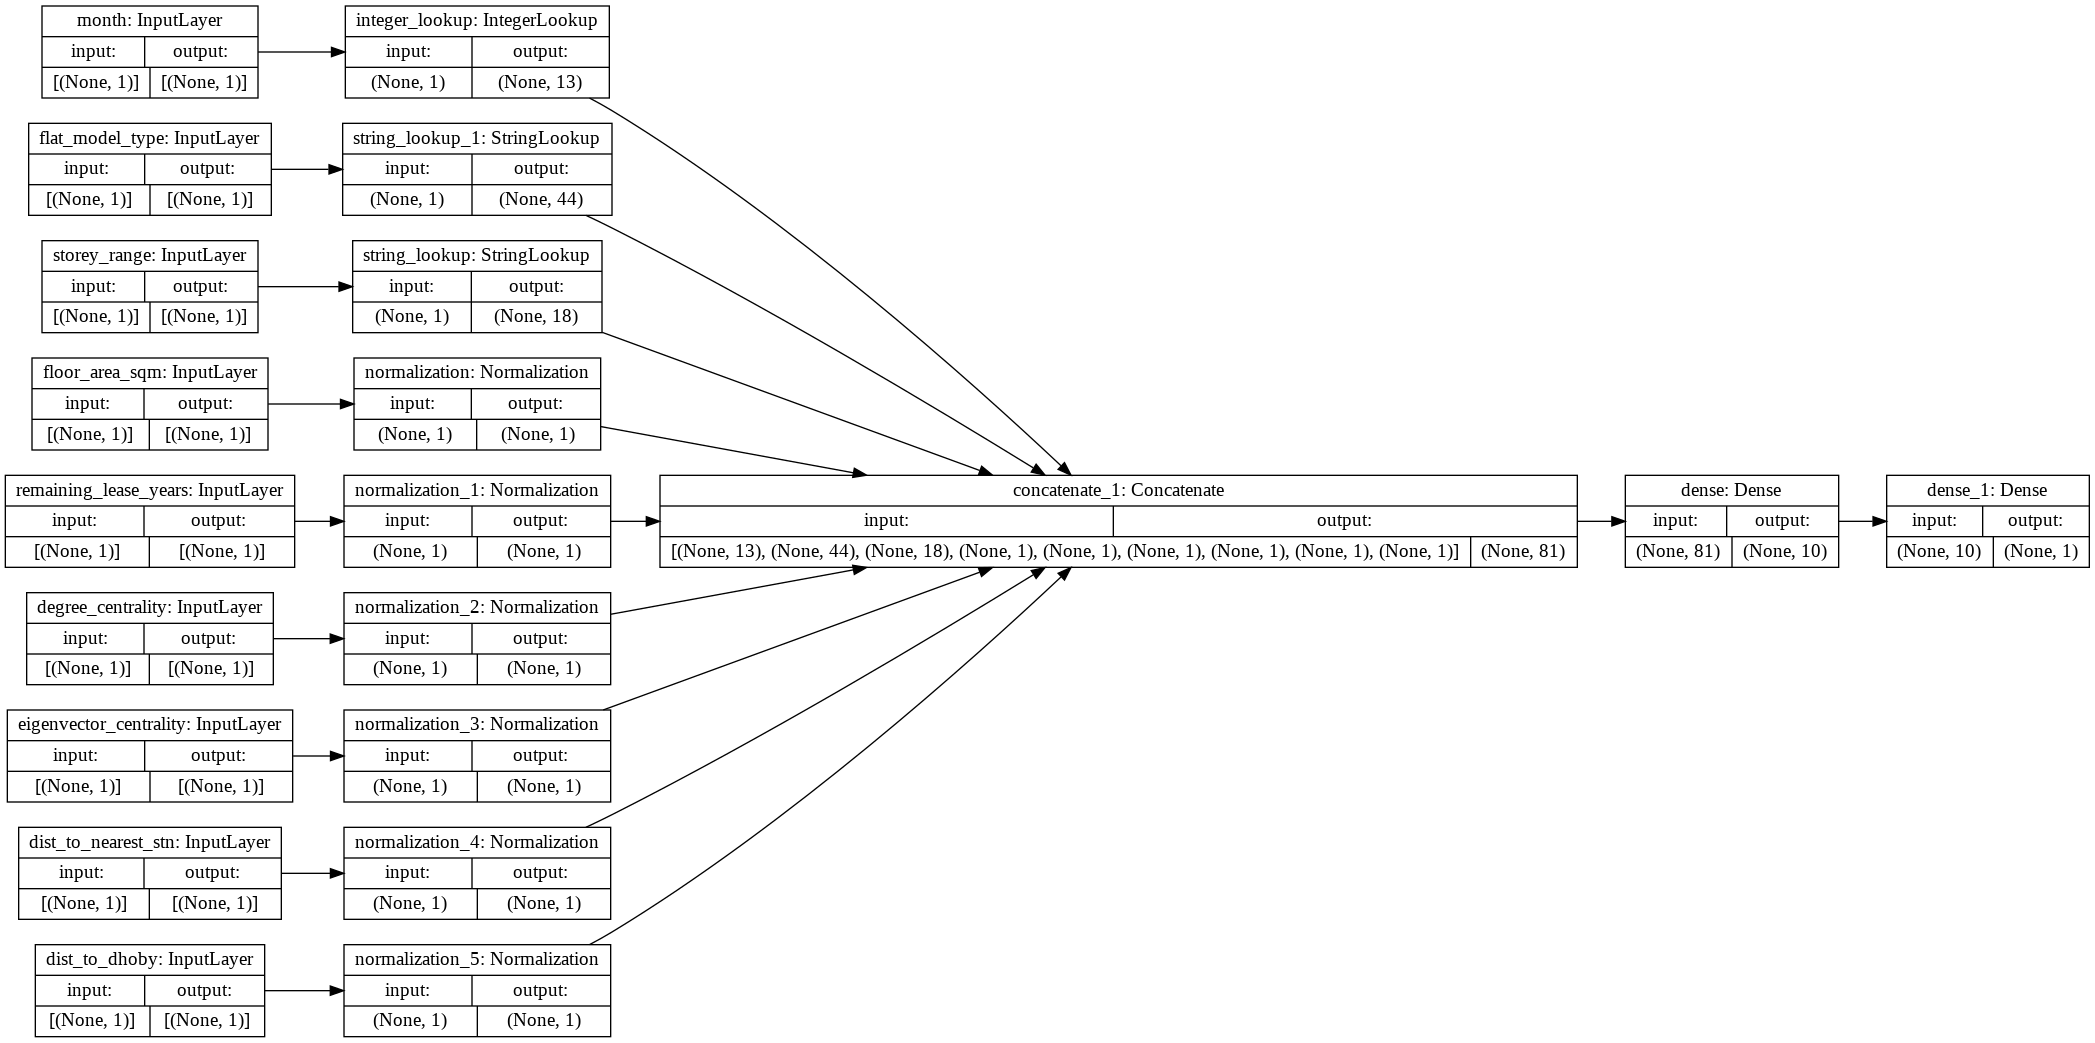

In [ ]:
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

**Part C**

Model compilation

In [ ]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor_area_sqm (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

Model Training

In [ ]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 187175714816.0000 - R2: -7.0488 - val_loss: 170701799424.0000 - val_R2: -5.6974
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 67175251968.0000 - R2: -1.8795 - val_loss: 39795949568.0000 - val_R2: -0.5496
Epoch 3/100
683/683 [==============================] - 4s 5ms/step - loss: 10803833856.0000 - R2: 0.5421 - val_loss: 11000638464.0000 - val_R2: 0.5751
Epoch 4/100
683/683 [==============================] - 3s 5ms/step - loss: 5527165440.0000 - R2: 0.7650 - val_loss: 8574937088.0000 - val_R2: 0.6689
Epoch 5/100
683/683 [==============================] - 3s 5ms/step - loss: 4987610112.0000 - R2: 0.7872 - val_loss: 7978337792.0000 - val_R2: 0.6912
Epoch 6/100
683/683 [==============================] - 4s 5ms/step - loss: 4625724416.0000 - R2: 0.8025 - val_loss: 7678568960.0000 - val_R2: 0.7038
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 4363144192.0000 - R2: 0.8140 - 

**Part D**

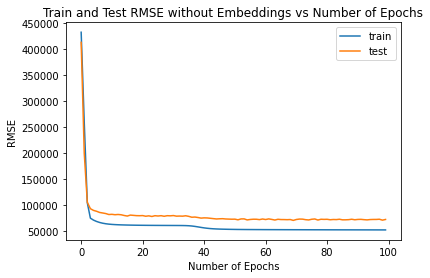

In [ ]:
import math
import matplotlib.pyplot as plt

history.history['root_mean_squared_error'] = []
history.history['val_root_mean_squared_error'] = []

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("Train and Test RMSE without Embeddings vs Number of Epochs")
plt.ylabel('RMSE')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


**Part E**

In [ ]:
test_loss = history.history['val_root_mean_squared_error']

min_epoch_loss_without_embedding = 0
min_loss_without_embedding = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss_without_embedding:
        min_loss_without_embedding = loss
        min_epoch_loss_without_embedding = i+1

print(min_epoch_loss_without_embedding)



70


Therefore, the epoch with the lowest test error is 70



In [ ]:
history.history['val_R2'][min_epoch_loss_without_embedding-1]

0.8073295950889587

R2 score at epoch 98 is: **0.8031396269798279**

**Part F**

Loading the weights from the saved model

In [ ]:
model.load_weights(checkpoint_filepath)

Extracting the first batch comprising of 128 test samples and making predictions on them. 

In [ ]:
first_test_batch = val_ds.take(1)
first_test_batch_predictions = model.predict(first_test_batch)
first_test_batch_true_values = np.concatenate([y for x, y in first_test_batch], axis=0)

Scatter plot between true and predicted values

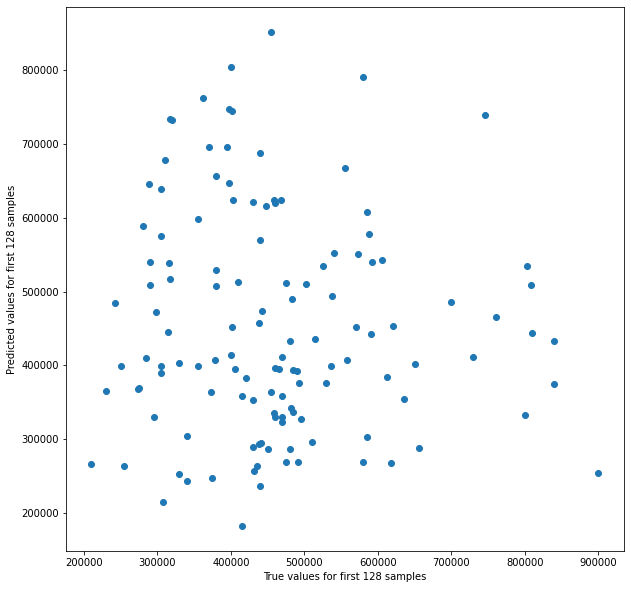

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.xlabel('True values for first 128 samples')
plt.ylabel('Predicted values for first 128 samples')
plt.scatter(first_test_batch_true_values, first_test_batch_predictions)

# Question 2

**Parts A and B**

The cell below preprocesses the data by encoding the numerical and further embedding and flattening the categorical features and finally, it concatenates all the layers

In [ ]:
unique_month_counts = len(df['month'].value_counts())
unique_storey_range_counts = len(df['storey_range'].value_counts())
unique_flat_model_type_counts = len(df['flat_model_type'].value_counts())

In [ ]:

# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature_for_embeddings(month, "month", train_ds, False)
month_embedder = tf.keras.layers.Embedding(input_dim = unique_month_counts+1, output_dim = (unique_month_counts//2), trainable=True)(month_encoded)
month_embedder_flattened = Reshape((-1,))(month_embedder)



# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature_for_embeddings(storey_range, "storey_range", train_ds, True)
storey_range_embedder = tf.keras.layers.Embedding(input_dim = unique_storey_range_counts+1, output_dim = (unique_storey_range_counts//2), trainable=True)(storey_range_encoded)
storey_range_embedder_flattened = Reshape((-1,))(storey_range_embedder)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature_for_embeddings(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_embedder = tf.keras.layers.Embedding(input_dim = unique_flat_model_type_counts+1, output_dim = (unique_flat_model_type_counts//2), trainable=True)(flat_model_type_encoded)
flat_model_type_embedder_flattened = Reshape((-1,))(flat_model_type_embedder)




# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)


all_features = layers.concatenate(
    [
        month_embedder_flattened,
        flat_model_type_embedder_flattened,
        storey_range_embedder_flattened,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]




 The cell below represents a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer

In [ ]:
# feedforward network with one hidden layer
tf.keras.backend.clear_session()
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model2 = keras.Model(all_inputs, output)



Model Summary

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           month[0][0]                      
______________________________________________________________________________________________

Model Architecture

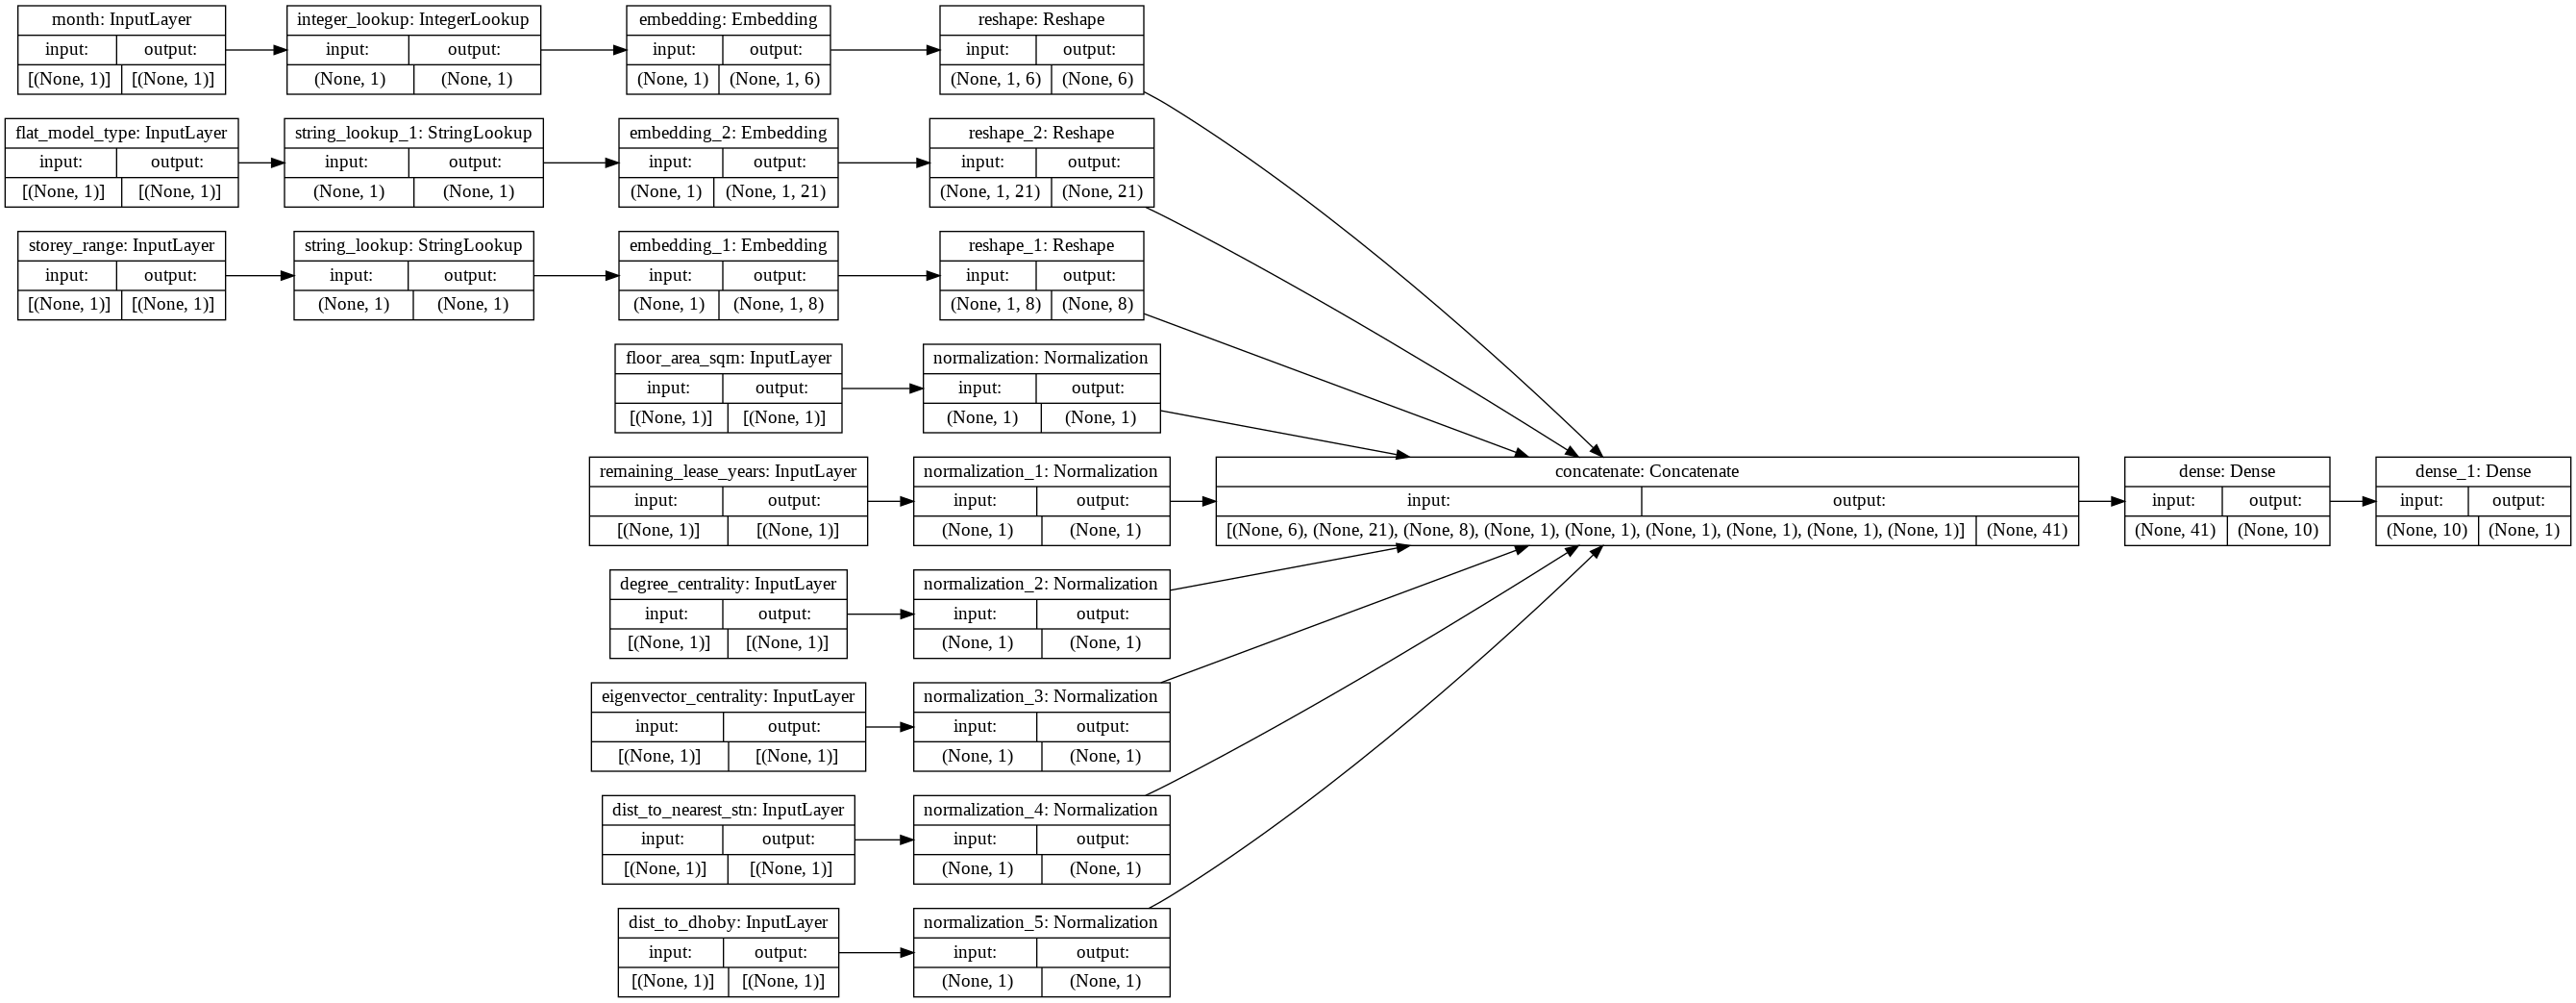

In [ ]:
keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")

Model Compilation

In [ ]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model2.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [ ]:
history2 = model2.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 5s 5ms/step - loss: 46453706752.0000 - R2: -1.0006 - val_loss: 11952966656.0000 - val_R2: 0.5395
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 8081560064.0000 - R2: 0.6548 - val_loss: 9835521024.0000 - val_R2: 0.6203
Epoch 3/100
683/683 [==============================] - 4s 5ms/step - loss: 7014366208.0000 - R2: 0.6999 - val_loss: 8870025216.0000 - val_R2: 0.6568
Epoch 4/100
683/683 [==============================] - 4s 5ms/step - loss: 6262458880.0000 - R2: 0.7318 - val_loss: 8415875072.0000 - val_R2: 0.6729
Epoch 5/100
683/683 [==============================] - 4s 5ms/step - loss: 5589031936.0000 - R2: 0.7609 - val_loss: 7760493568.0000 - val_R2: 0.7002
Epoch 6/100
683/683 [==============================] - 4s 5ms/step - loss: 5084145152.0000 - R2: 0.7822 - val_loss: 7298960896.0000 - val_R2: 0.7156
Epoch 7/100
683/683 [==============================] - 4s 5ms/step - loss: 4721801728.0000 - R2: 0.7976 - val_loss:

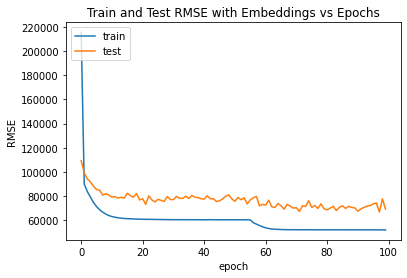

In [ ]:
import math
import matplotlib.pyplot as plt

history2.history['root_mean_squared_error'] = []
history2.history['val_root_mean_squared_error'] = []

for i in range(len(history2.history['loss'])):
    history2.history['root_mean_squared_error'].append(math.sqrt(history2.history['loss'][i]))

for i in range(len(history2.history['val_loss'])):
    history2.history['val_root_mean_squared_error'].append(math.sqrt(history2.history['val_loss'][i]))

plt.plot(history2.history['root_mean_squared_error'])
plt.plot(history2.history['val_root_mean_squared_error'])
plt.title('Train and Test RMSE with Embeddings vs Epochs')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Part C**

In [ ]:
test_loss = history2.history['val_root_mean_squared_error']

min_epoch_loss_with_embedding = 0
min_loss_with_embedding = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss_with_embedding:
        min_loss_with_embedding = loss
        min_epoch_loss_with_embedding = i+1

print("Best Epoch with Embedding: "+str(min_epoch_loss_with_embedding))
print("RMSE at the best epoch with Embedding: "+str(min_loss_with_embedding))
print("R2 value at the best epoch with Embedding: "+str(history2.history['val_R2'][min_epoch_loss_with_embedding-1]))
print("\n\n")
print("Best Epoch without Embedding: "+str(min_epoch_loss_without_embedding))
print("RMSE at the best epoch without Embedding: "+str(min_loss_without_embedding))
print("R2 value at the best epoch without Embedding: "+str(history.history['val_R2'][min_epoch_loss_without_embedding-1]))



Best Epoch with Embedding: 98
RMSE at the best epoch with Embedding: 66868.427706953
R2 value at the best epoch with Embedding: 0.8247413039207458



Best Epoch without Embedding: 70
RMSE at the best epoch without Embedding: 70049.67745821533
R2 value at the best epoch without Embedding: 0.8073295950889587


Therefore, 

*   R2 score with embedding at best epoch > R2 score without embedding at best epoch
*   RMSE score with embedding at best epoch < RMSE score without embedding at best epoch



Therefore, from the above 2 conclusions we can clearly see that the model with Embeddings has performed better than the one without it at their best epochs. The reason behind this is that when we encode the categorical data in the form of an embedding matrix instead of a one-hot representation, more meaningful relationships can be discovered among the categories. For example, if there is a trend in the data that the prices of HDBs are high during few months, the embedding matrix can capture that piece of information by putting the embedding matrices of those months closer together than the others. 

# Question 3

**Part A**

Model definition and Compilation

In [ ]:
tf.keras.backend.clear_session()
from keras import backend as K

# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model3 = keras.Model(all_inputs, output)

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model3.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

Training the model with Early Stopping at a patience of 10 epochs

In [ ]:
tf.keras.backend.clear_session()
history3 = model3.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 5s 5ms/step - loss: 38306476032.0000 - R2: -0.6608 - val_loss: 10928161792.0000 - val_R2: 0.5785
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 8046232064.0000 - R2: 0.6555 - val_loss: 10117093376.0000 - val_R2: 0.6075
Epoch 3/100
683/683 [==============================] - 4s 5ms/step - loss: 7299630080.0000 - R2: 0.6878 - val_loss: 9040779264.0000 - val_R2: 0.6481
Epoch 4/100
683/683 [==============================] - 4s 5ms/step - loss: 6613557760.0000 - R2: 0.7167 - val_loss: 8417948672.0000 - val_R2: 0.6739
Epoch 5/100
683/683 [==============================] - 4s 5ms/step - loss: 5917479424.0000 - R2: 0.7467 - val_loss: 7846651904.0000 - val_R2: 0.6945
Epoch 6/100
683/683 [==============================] - 4s 5ms/step - loss: 5330835456.0000 - R2: 0.7726 - val_loss: 7240659968.0000 - val_R2: 0.7184
Epoch 7/100
683/683 [==============================] - 4s 5ms/step - loss: 4910738944.0000 - R2: 0.7892 - val_loss

**Part B**

The cell below contains the function to build and train the model for question 3

In [ ]:
def build_and_train_model_question3(embeddings_list, epochs):
    all_features = layers.concatenate(embeddings_list)
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    return history


RFE Implementation

In [57]:
import math
tf.keras.backend.clear_session()

scores = {}
history = {}

features_to_embeddings = {
    'month': month_embedder_flattened,
    'flat_model_type': flat_model_type_embedder_flattened,
    'storey_range': storey_range_embedder_flattened,
    'floor_area_sqm': floor_area_sqm_encoded,
    'remaining_lease_years': remaining_lease_years_encoded,
    'degree_centrality': degree_centrality_encoded,
    'eigenvector_centrality': eigenvector_centrality_encoded,
    'dist_to_nearest_stn': dist_to_nearest_stn_encoded,
    'dist_to_dhoby': dist_to_dhoby_encoded
}

initial_features = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]

def convert_features_list_to_embeddings(features_list):
    embeddings_list = []
    for feature in features_list:
        embeddings_list.append(features_to_embeddings[feature])
    return embeddings_list





def calculate_best_epoch_R2_and_RMSE(history):
    r2_scores = history.history['val_R2']
    mse = history.history['val_loss']
    best_epoch = 1
    for i in range(len(r2_scores)):
        if r2_scores[i]>r2_scores[best_epoch-1]:
            best_epoch = i+1
    return [r2_scores[best_epoch-1],math.sqrt(mse[best_epoch-1])]





def RFE(previous_r2_rmse_values,features_list, scores, depth):
    if not features_list or len(features_list)==1:
        return
    print(scores)
    max_r2_score_of_children_nodes = float("-inf")
    min_rmse_of_children_nodes = float("inf")
    max_features_list = []
    for i,feature in enumerate(features_list):
        new_features_list = features_list[:i]+features_list[i+1:]
        new_embeddings_list = convert_features_list_to_embeddings(new_features_list)
        tf.keras.backend.clear_session()
        history = build_and_train_model_question3(new_embeddings_list, 100)
        r2,rmse = calculate_best_epoch_R2_and_RMSE(history)
        scores[tuple(new_features_list)] = [r2,rmse]
        print(scores)
        if r2>=max_r2_score_of_children_nodes:
            max_r2_score_of_children_nodes = r2
            min_rmse_of_children_nodes = rmse
            max_features_list = new_features_list
    prev_r2, prev_rmse = previous_r2_rmse_values
    if depth>0 and max_r2_score_of_children_nodes<prev_r2: 
        return
    else:
        RFE([max_r2_score_of_children_nodes,min_rmse_of_children_nodes], max_features_list, scores, depth+1)
    
    # scores[tuple(max_features_list)] = [max_r2_score_of_children_nodes,min_rmse_of_children_nodes]
    

best_r2_and_rmse_score_all_features = calculate_best_epoch_R2_and_RMSE(history3)
scores[tuple(initial_features)] = best_r2_and_rmse_score_all_features
RFE(best_r2_and_rmse_score_all_features, initial_features, scores, 0)
print(scores)
    



{('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby'): [0.7778990268707275, 75490.424717311]}
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 6s 6ms/step - loss: 24895080448.0000 - R2: -0.0600 - val_loss: 10552118272.0000 - val_R2: 0.5905
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 8555018752.0000 - R2: 0.6339 - val_loss: 10803611648.0000 - val_R2: 0.5816
Epoch 3/100
683/683 [==============================] - 5s 6ms/step - loss: 8384259072.0000 - R2: 0.6411 - val_loss: 9783254016.0000 - val_R2: 0.6195
Epoch 4/100
683/683 [==============================] - 5s 6ms/step - loss: 8179715584.0000 - R2: 0.6496 - val_loss: 9720709120.0000 - val_R2: 0.6246
Epoch 5/100
683/683 [==============================] - 4s 6ms/step - loss: 7891098624.0000 - R2: 0.6624 - val_loss: 11043654656.0000 - val_R2: 0.5723
Epoch 6/100
683/683 [==============================] - 4s 5ms/step - loss: 7494701056.0000 - R2: 0.6794 - val_loss: 9798128640.0000 - val_R2: 0.6195
Epoch 7/100
683/683 [==============================] - 4s 5ms/step - loss: 6958071808.0000 - R2: 0.7021 - val_los

In [65]:
total_features = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]
eliminated_features = []
r2_scores_list = []
root_mean_square_error_list = []

for feature_tuple in scores.keys():
    elim_feat=[]
    for feature in total_features:
        if feature not in feature_tuple:
            elim_feat.append(feature)
    if len(elim_feat)==0:
       eliminated_features.append("No features eliminated") 
    else:
        eliminated_features.append(elim_feat)
    r2_scores_list.append(scores[feature_tuple][0])
    root_mean_square_error_list.append(scores[feature_tuple][1])

In [66]:
rfe_table = pd.DataFrame(list(zip(eliminated_features , r2_scores_list , root_mean_square_error_list)) , columns=['Eliminated features','R2_Score','Root_Mean_Square_Error'])

In [67]:
%load_ext google.colab.data_table
rfe_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Eliminated features,R2_Score,Root_Mean_Square_Error
0,No features eliminated,0.777899,75490.424717
1,[month],0.849211,62068.062770
2,[flat_model_type],-9.694881,523438.076720
3,[storey_range],0.816727,68622.890175
4,[floor_area_sqm],0.812471,69438.573257
5,[remaining_lease_years],0.810474,69642.892530
6,[degree_centrality],0.841438,63668.939743
7,[eigenvector_centrality],0.824224,67173.457615
8,[dist_to_nearest_stn],0.778797,75426.548960
9,[dist_to_dhoby],0.704551,87175.101032
